## Fraud Detection Model Training

In [1]:
## 1. Setup and Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import warnings

# import src functions 
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
from data_preprocessing import apply_data_processing
from feature_engineering import apply_feature_engineering
from model_evaluation import evaluate_models 

warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    try:
        plt.style.use('seaborn')
    except OSError:
        plt.style.use('default')
        print("Using default matplotlib style")

sns.set_palette("husl")

# Import custom modules (uncomment when available)
# from data_processing import FraudDataPreprocessor
# from feature_engineering import FraudFeatureEngineering

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [2]:
## 2. Data Loading and Initial Exploration

def load_data(file_path):
    """Load and perform initial exploration of the dataset"""
    print("="*60)
    print("DATA LOADING AND EXPLORATION")
    print("="*60)
    
    # Load data
    df = pd.read_csv(file_path)
    print(f"✓ Data loaded successfully")
    print(f"✓ Shape: {df.shape}")
    print(f"✓ Columns: {list(df.columns)}")
    
    # Basic info
    print(f"\nDataset Info:")
    print(f"- Total transactions: {len(df):,}")
    print(f"- Features: {df.shape[1] - 1}")
    print(f"- Missing values: {df.isnull().sum().sum()}")
    print(f"- Duplicates: {df.duplicated().sum()}")
    
    # Target distribution
    if 'Class' in df.columns:
        fraud_count = df['Class'].sum()
        fraud_rate = fraud_count / len(df)
        print(f"- Fraud transactions: {fraud_count:,}")
        print(f"- Fraud rate: {fraud_rate:.4f} ({fraud_rate*100:.2f}%)")
    
    return df

# Load your dataset
# Replace with your actual file path
file_path = "../data/raw/creditcard.csv"  # Update this path
df = load_data(file_path)

DATA LOADING AND EXPLORATION
✓ Data loaded successfully
✓ Shape: (284807, 31)
✓ Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Dataset Info:
- Total transactions: 284,807
- Features: 30
- Missing values: 0
- Duplicates: 1081
- Fraud transactions: 492
- Fraud rate: 0.0017 (0.17%)


In [3]:
## 3. Data Processing Function
# Apply data processing
df_processed = apply_data_processing(df, target_column='Class')

## 4. Feature Engineering Function
# Apply feature engineering
df_final = apply_feature_engineering(df_processed)


APPLYING DATA PROCESSING
✓ Handled missing values for 30 numerical columns
✓ Handled 370372 outliers across all numerical columns
✓ Scaled 30 numerical features
✓ Data processing completed

APPLYING FEATURE ENGINEERING
Creating time-based features...
Creating amount-based features...
Creating PCA-based features from 28 V columns...
Creating risk score features...
✓ Feature engineering completed
✓ Original features: 30
✓ New features: 59
✓ Added features: 29


In [4]:
## 5. Data Preparation for Model Training

def prepare_training_data(df, target_column='Class', test_size=0.2):
    """Prepare data for model training"""
    print("\n" + "="*60)
    print("PREPARING DATA FOR MODEL TRAINING")
    print("="*60)
    
    # Separate features and target
    X = df.drop([target_column], axis=1)
    y = df[target_column]
    
    print(f"✓ Total features: {X.shape[1]}")
    print(f"✓ Total samples: {X.shape[0]}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size,
        random_state=42,
        stratify=y
    )
    
    print(f"✓ Training set: {X_train.shape[0]} samples")
    print(f"✓ Test set: {X_test.shape[0]} samples")
    print(f"✓ Training fraud rate: {y_train.mean():.4f}")
    print(f"✓ Test fraud rate: {y_test.mean():.4f}")
    
    return X_train, X_test, y_train, y_test

# Prepare training data
X_train, X_test, y_train, y_test = prepare_training_data(df_final)


PREPARING DATA FOR MODEL TRAINING
✓ Total features: 59
✓ Total samples: 284807
✓ Training set: 227845 samples
✓ Test set: 56962 samples
✓ Training fraud rate: 0.0017
✓ Test fraud rate: 0.0017


In [5]:
## 6. Feature Selection

def select_best_features(X_train, y_train, k=50):
    """Select top k features using univariate feature selection"""
    print(f"\n" + "="*60)
    print(f"FEATURE SELECTION (Top {k} features)")
    print("="*60)
    
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    
    # Get selected feature names
    selected_features = X_train.columns[selector.get_support()].tolist()
    print(f"✓ Selected {len(selected_features)} features")
    
    return selector, selected_features

# Select best features
selector, selected_features = select_best_features(X_train, y_train, k=50)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

print(f"Selected features: {selected_features[:10]}...")  # Show first 10


FEATURE SELECTION (Top 50 features)
✓ Selected 50 features
Selected features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']...


In [6]:
## 7. Model Training - Lasso Regression

def train_lasso_model(X_train, y_train, X_test, y_test):
    """Train and evaluate Lasso regression model"""
    print("\n" + "="*60)
    print("TRAINING LASSO REGRESSION MODEL")
    print("="*60)
    
    # Define parameter grid for Lasso
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [1000, 5000, 10000]
    }
    
    # Initialize Lasso
    lasso = Lasso(random_state=42)
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        lasso, 
        param_grid, 
        cv=5, 
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model
    print("Performing grid search...")
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_lasso = grid_search.best_estimator_
    print(f"✓ Best parameters: {grid_search.best_params_}")
    print(f"✓ Best CV score: {grid_search.best_score_:.4f}")
    
    # Make predictions
    y_pred_lasso = best_lasso.predict(X_test)
    y_pred_proba_lasso = best_lasso.predict(X_test)  # Lasso gives continuous predictions
    
    # Convert predictions to binary (threshold at 0.5)
    y_pred_binary_lasso = (y_pred_proba_lasso > 0.5).astype(int)
    
    # Calculate metrics
    auc_lasso = roc_auc_score(y_test, y_pred_proba_lasso)
    
    print(f"✓ Test AUC: {auc_lasso:.4f}")
    
    return best_lasso, y_pred_binary_lasso, y_pred_proba_lasso

# Train Lasso model
lasso_model, y_pred_lasso, y_pred_proba_lasso = train_lasso_model(
    X_train_selected, y_train, X_test_selected, y_test
)


TRAINING LASSO REGRESSION MODEL
Performing grid search...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✓ Best parameters: {'alpha': 0.01, 'max_iter': 1000}
✓ Best CV score: 0.9449
✓ Test AUC: 0.9502


In [10]:
## 8. Model Training - Logistic Regression

def train_logistic_model(X_train, y_train, X_test, y_test):
    """Train and evaluate Logistic Regression model"""
    print("\n" + "="*60)
    print("TRAINING LOGISTIC REGRESSION MODEL")
    print("="*60)
    
    import time
    start_time = time.time()
    
    # Optimized parameter grid for <1 minute training
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [1000]
    }
    
    # Initialize Logistic Regression
    logreg = LogisticRegression(random_state=42, class_weight='balanced')
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        logreg,
        param_grid,
        cv=2,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model
    print("Performing grid search...")
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_logreg = grid_search.best_estimator_
    print(f"✓ Best parameters: {grid_search.best_params_}")
    print(f"✓ Best CV score: {grid_search.best_score_:.4f}")
    
    # Make predictions
    y_pred_logreg = best_logreg.predict(X_test)
    y_pred_proba_logreg = best_logreg.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)
    
    training_time = time.time() - start_time
    print(f"✓ Training completed in {training_time:.2f} seconds")
    print(f"✓ Test AUC: {auc_logreg:.4f}")
    
    return best_logreg, y_pred_logreg, y_pred_proba_logreg

# Train Logistic Regression model
logreg_model, y_pred_logreg, y_pred_proba_logreg = train_logistic_model(
    X_train_selected, y_train, X_test_selected, y_test
)


TRAINING LOGISTIC REGRESSION MODEL
Performing grid search...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
✓ Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
✓ Best CV score: 0.9810
✓ Training completed in 24.79 seconds
✓ Test AUC: 0.9726


In [14]:
## 9. Model Training - Random Forest (Bagging)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import time

def train_random_forest_model(X_train, y_train, X_test, y_test):
    """Train and evaluate Random Forest model"""
    print("\n" + "="*60)
    print("TRAINING RANDOM FOREST MODEL (BAGGING)")
    print("="*60)
    
    start_time = time.time()
    
    # Ultra-minimal parameter grid for <1 minute training
    param_grid = {
        'n_estimators': [50, 100],          # Only 2 values
        'max_depth': [10],                  # Single value
        'min_samples_split': [2],           # Single value
        'min_samples_leaf': [1],            # Single value
        'max_features': ['sqrt']            # Single value
    }
    
    # Initialize Random Forest with speed optimizations
    rf = RandomForestClassifier(
        random_state=42, 
        class_weight='balanced',
        n_jobs=-1,      # Use all cores for individual trees
        bootstrap=True, # Enable bootstrap for speed
        oob_score=False # Disable OOB for speed
    )
    
    # Minimal grid search
    grid_search = GridSearchCV(
        rf,
        param_grid,
        cv=2,           # Minimal CV folds
        scoring='roc_auc',
        n_jobs=1,       # Single job for grid search
        verbose=0       # Disable verbose for speed
    )
    
    # Fit the model
    print("Performing ultra-fast grid search...")
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_rf = grid_search.best_estimator_
    print(f"✓ Best parameters: {grid_search.best_params_}")
    print(f"✓ Best CV score: {grid_search.best_score_:.4f}")
    
    # Make predictions
    y_pred_rf = best_rf.predict(X_test)
    y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
    
    training_time = time.time() - start_time
    print(f"✓ Training completed in {training_time:.2f} seconds")
    print(f"✓ Test AUC: {auc_rf:.4f}")
    
    if training_time > 60:
        print("⚠ Warning: Training exceeded 1 minute")
    
    return best_rf, y_pred_rf, y_pred_proba_rf

# Train Random Forest model
rf_model, y_pred_rf, y_pred_proba_rf = train_random_forest_model(
    X_train_selected, y_train, X_test_selected, y_test
)


TRAINING RANDOM FOREST MODEL (BAGGING)
Performing ultra-fast grid search...
✓ Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
✓ Best CV score: 0.9647
✓ Training completed in 38.35 seconds
✓ Test AUC: 0.9795


In [16]:
## 10. Model Training - XGBoost (Boosting)

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import time

def train_xgboost_model(X_train, y_train, X_test, y_test):
    """Train and evaluate XGBoost model"""
    print("\n" + "="*60)
    print("TRAINING XGBOOST MODEL (BOOSTING)")
    print("="*60)
    
    start_time = time.time()
    
    # Calculate scale_pos_weight for class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    # Ultra-minimal parameter grid for <1 minute training
    param_grid = {
        'n_estimators': [50, 100],          # Only 2 values
        'max_depth': [3, 5],                # Only 2 values
        'learning_rate': [0.1],             # Single value
        'subsample': [0.8],                 # Single value
        'colsample_bytree': [0.8]           # Single value
    }
    
    # Initialize XGBoost with speed optimizations
    xgb_model = xgb.XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,                          # Use all cores
        tree_method='hist',                 # Faster tree method
        verbosity=0                         # Disable verbose for speed
    )
    
    # Minimal grid search
    grid_search = GridSearchCV(
        xgb_model,
        param_grid,
        cv=2,           # Minimal CV folds for speed
        scoring='roc_auc',
        n_jobs=1,       # Single job for grid search (XGB already uses all cores)
        verbose=0       # Disable verbose for speed
    )
    
    # Fit the model
    print("Performing ultra-fast grid search...")
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_xgb = grid_search.best_estimator_
    print(f"✓ Best parameters: {grid_search.best_params_}")
    print(f"✓ Best CV score: {grid_search.best_score_:.4f}")
    
    # Make predictions
    y_pred_xgb = best_xgb.predict(X_test)
    y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
    
    training_time = time.time() - start_time
    print(f"✓ Training completed in {training_time:.2f} seconds")
    print(f"✓ Test AUC: {auc_xgb:.4f}")
    
    if training_time > 60:
        print("⚠ Warning: Training exceeded 1 minute")
    
    return best_xgb, y_pred_xgb, y_pred_proba_xgb

# Train XGBoost model
xgb_model, y_pred_xgb, y_pred_proba_xgb = train_xgboost_model(
    X_train_selected, y_train, X_test_selected, y_test
)


TRAINING XGBOOST MODEL (BOOSTING)
Performing ultra-fast grid search...
✓ Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
✓ Best CV score: 0.9801
✓ Training completed in 8.07 seconds
✓ Test AUC: 0.9809


In [18]:
## 11. Model Training - Neural Network (MLP)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

def train_neural_network_model(X_train, y_train, X_test, y_test):
    """Train and evaluate Neural Network model"""
    print("\n" + "="*60)
    print("TRAINING NEURAL NETWORK MODEL (MLP)")
    print("="*60)
    
    # Define parameter grid for Neural Network - Reduced for speed
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Reduced options
        'activation': ['relu'],  # Only relu for speed
        'alpha': [0.001, 0.01],  # Reduced options
        'learning_rate': ['adaptive'],  # Only adaptive
        'max_iter': [300, 500]  # Reduced max iterations
    }
    
    # Initialize Neural Network
    mlp = MLPClassifier(
        random_state=42, 
        early_stopping=True, 
        validation_fraction=0.1,
        n_iter_no_change=10  # Stop early if no improvement
    )
    
    # Use RandomizedSearchCV instead of GridSearchCV for speed
    grid_search = RandomizedSearchCV(
        mlp, 
        param_grid,
        n_iter=8,  # Only try 8 random combinations instead of all
        cv=3,  # Keep 3-fold CV
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    # Fit the model
    print("Performing grid search...")
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_mlp = grid_search.best_estimator_
    print(f"✓ Best parameters: {grid_search.best_params_}")
    print(f"✓ Best CV score: {grid_search.best_score_:.4f}")
    
    # Make predictions
    y_pred_mlp = best_mlp.predict(X_test)
    y_pred_proba_mlp = best_mlp.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)
    
    print(f"✓ Test AUC: {auc_mlp:.4f}")
    
    return best_mlp, y_pred_mlp, y_pred_proba_mlp

# Train Neural Network model
mlp_model, y_pred_mlp, y_pred_proba_mlp = train_neural_network_model(
    X_train_selected, y_train, X_test_selected, y_test
)


TRAINING NEURAL NETWORK MODEL (MLP)
Performing grid search...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✓ Best parameters: {'max_iter': 500, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'relu'}
✓ Best CV score: 0.9783
✓ Test AUC: 0.9768



COMPREHENSIVE MODEL EVALUATION AND COMPARISON

LASSO RESULTS:
--------------------------------------------------
AUC Score: 0.9502
F1 Score: 0.0000
Average Precision: 0.3262

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


LOGISTIC REGRESSION RESULTS:
--------------------------------------------------
AUC Score: 0.9726
F1 Score: 0.0885
Average Precision: 0.7012

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.91      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97   

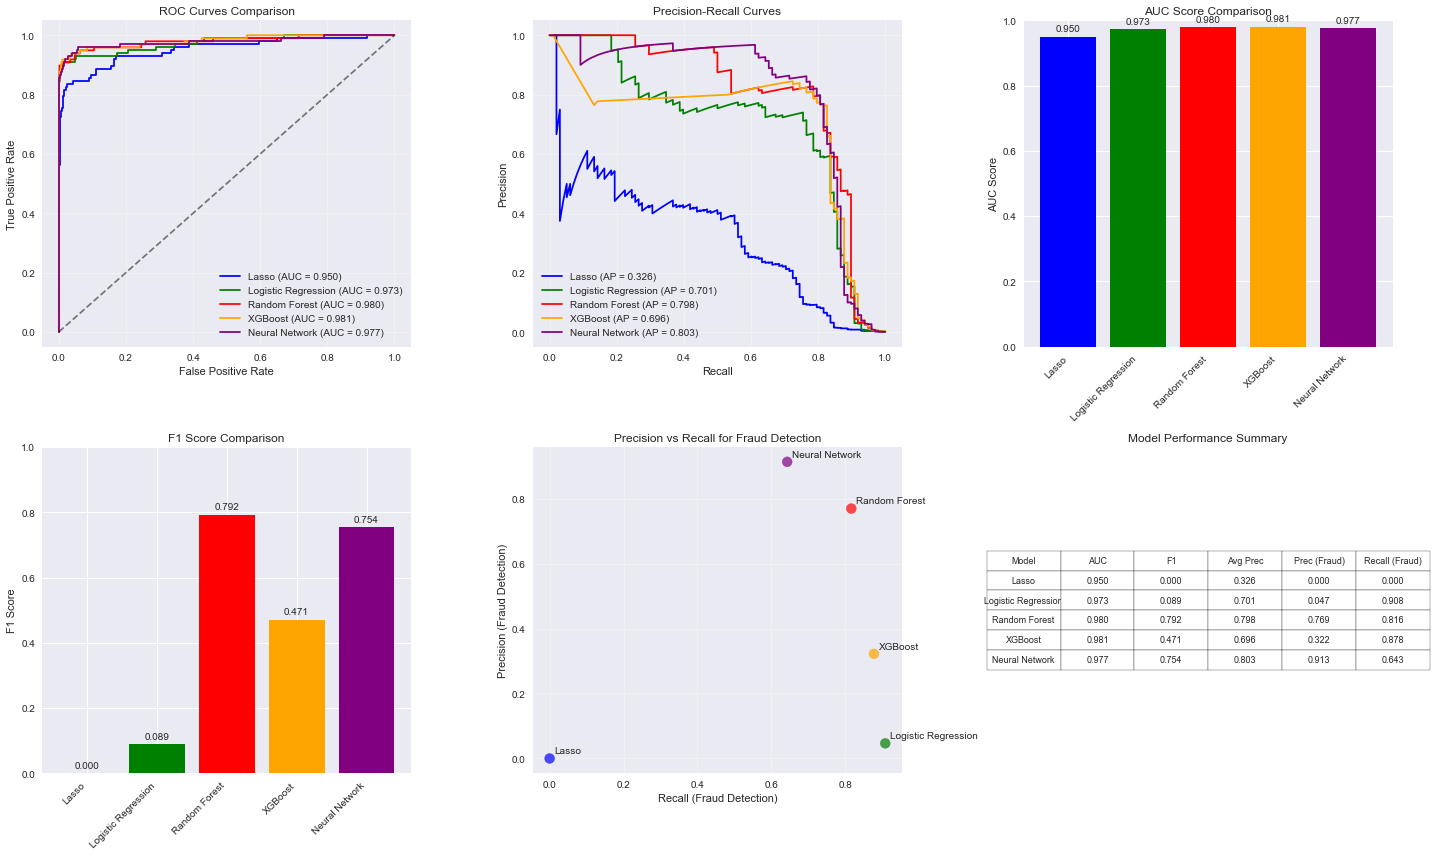


MODEL RANKING BY AUC SCORE
1. XGBoost: AUC = 0.9809
2. Random Forest: AUC = 0.9795
3. Neural Network: AUC = 0.9768
4. Logistic Regression: AUC = 0.9726
5. Lasso: AUC = 0.9502

DETAILED RESULTS TABLE
                        AUC  F1_Score  Average_Precision  Precision_Fraud  \
Lasso                0.9502    0.0000             0.3262           0.0000   
Logistic Regression  0.9726    0.0885             0.7012           0.0465   
Random Forest        0.9795    0.7921             0.7977           0.7692   
XGBoost              0.9809    0.4712             0.6964           0.3221   
Neural Network       0.9768    0.7545             0.8030           0.9130   

                     Recall_Fraud  Precision_Normal  Recall_Normal  
Lasso                      0.0000            0.9983         1.0000  
Logistic Regression        0.9082            0.9998         0.9679  
Random Forest              0.8163            0.9997         0.9996  
XGBoost                    0.8776            0.9998         0

In [24]:
## 12. Comprehensive Model Evaluation and Comparison
from sklearn.metrics import (roc_auc_score, f1_score, average_precision_score, 
                            classification_report, roc_curve, precision_recall_curve)

def evaluate_all_models(y_test, models_predictions):
    """Comprehensive evaluation and comparison of all models"""
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL EVALUATION AND COMPARISON")
    print("="*80)
    
    model_names = ['Lasso', 'Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network']
    
    # Calculate all metrics for each model
    results = {}
    
    for i, (name, (y_pred, y_pred_proba)) in enumerate(zip(model_names, models_predictions)):
        auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        
        # Get classification report as dict
        class_report = classification_report(y_test, y_pred, output_dict=True)
        
        results[name] = {
            'AUC': auc,
            'F1_Score': f1,
            'Average_Precision': avg_precision,
            'Precision_Fraud': class_report['1']['precision'],
            'Recall_Fraud': class_report['1']['recall'],
            'Precision_Normal': class_report['0']['precision'],
            'Recall_Normal': class_report['0']['recall']
        }
        
        print(f"\n{name.upper()} RESULTS:")
        print("-" * 50)
        print(f"AUC Score: {auc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    # Create comprehensive comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # ROC Curves
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    for i, (name, (y_pred, y_pred_proba)) in enumerate(zip(model_names, models_predictions)):
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        axes[0, 0].plot(fpr, tpr, color=colors[i], label=f'{name} (AUC = {auc:.3f})')
    
    axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curves Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Precision-Recall Curves
    for i, (name, (y_pred, y_pred_proba)) in enumerate(zip(model_names, models_predictions)):
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        axes[0, 1].plot(recall, precision, color=colors[i], 
                       label=f'{name} (AP = {avg_precision:.3f})')
    
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curves')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # AUC Comparison Bar Chart
    model_aucs = [results[name]['AUC'] for name in model_names]
    bars = axes[0, 2].bar(model_names, model_aucs, color=colors)
    axes[0, 2].set_ylabel('AUC Score')
    axes[0, 2].set_title('AUC Score Comparison')
    axes[0, 2].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, auc in zip(bars, model_aucs):
        height = bar.get_height()
        axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{auc:.3f}', ha='center', va='bottom')
    
    plt.setp(axes[0, 2].get_xticklabels(), rotation=45, ha='right')
    
    # F1 Score Comparison
    model_f1s = [results[name]['F1_Score'] for name in model_names]
    bars = axes[1, 0].bar(model_names, model_f1s, color=colors)
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title('F1 Score Comparison')
    axes[1, 0].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, f1 in zip(bars, model_f1s):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{f1:.3f}', ha='center', va='bottom')
    
    plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
    
    # Precision vs Recall for Fraud Detection
    fraud_precision = [results[name]['Precision_Fraud'] for name in model_names]
    fraud_recall = [results[name]['Recall_Fraud'] for name in model_names]
    
    scatter = axes[1, 1].scatter(fraud_recall, fraud_precision, c=colors, s=100, alpha=0.7)
    
    # Add model names as labels
    for i, name in enumerate(model_names):
        axes[1, 1].annotate(name, (fraud_recall[i], fraud_precision[i]), 
                           xytext=(5, 5), textcoords='offset points')
    
    axes[1, 1].set_xlabel('Recall (Fraud Detection)')
    axes[1, 1].set_ylabel('Precision (Fraud Detection)')
    axes[1, 1].set_title('Precision vs Recall for Fraud Detection')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Summary Table
    axes[1, 2].axis('tight')
    axes[1, 2].axis('off')
    
    # Create summary table
    summary_data = []
    for name in model_names:
        summary_data.append([
            name,
            f"{results[name]['AUC']:.3f}",
            f"{results[name]['F1_Score']:.3f}",
            f"{results[name]['Average_Precision']:.3f}",
            f"{results[name]['Precision_Fraud']:.3f}",
            f"{results[name]['Recall_Fraud']:.3f}"
        ])
    
    table = axes[1, 2].table(cellText=summary_data,
                            colLabels=['Model', 'AUC', 'F1', 'Avg Prec', 'Prec (Fraud)', 'Recall (Fraud)'],
                            cellLoc='center',
                            loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    axes[1, 2].set_title('Model Performance Summary')
    
    plt.tight_layout()
    plt.show()
    
    # Print ranking
    print("\n" + "="*60)
    print("MODEL RANKING BY AUC SCORE")
    print("="*60)
    
    # Sort models by AUC
    sorted_models = sorted(results.items(), key=lambda x: x[1]['AUC'], reverse=True)
    
    for i, (name, metrics) in enumerate(sorted_models, 1):
        print(f"{i}. {name}: AUC = {metrics['AUC']:.4f}")
    
    # Convert results to DataFrame for easy viewing
    results_df = pd.DataFrame(results).T
    print("\n" + "="*60)
    print("DETAILED RESULTS TABLE")
    print("="*60)
    print(results_df.round(4))
    
    return results, results_df

# Usage - Pass the predictions from all models
models_predictions = [
    (y_pred_lasso, y_pred_proba_lasso),           # Lasso predictions
    (y_pred_logreg,  y_pred_proba_logreg),     # Logistic Regression predictions
    (y_pred_rf, y_pred_proba_rf),                 # Random Forest predictions
    (y_pred_xgb, y_pred_proba_xgb),               # XGBoost predictions
    (y_pred_mlp, y_pred_proba_mlp)                # Neural Network predictions
]

# Run comprehensive evaluation
comparison_results, comparison_results_df = evaluate_all_models(y_test, models_predictions)


FEATURE IMPORTANCE ANALYSIS - FOUR MODELS


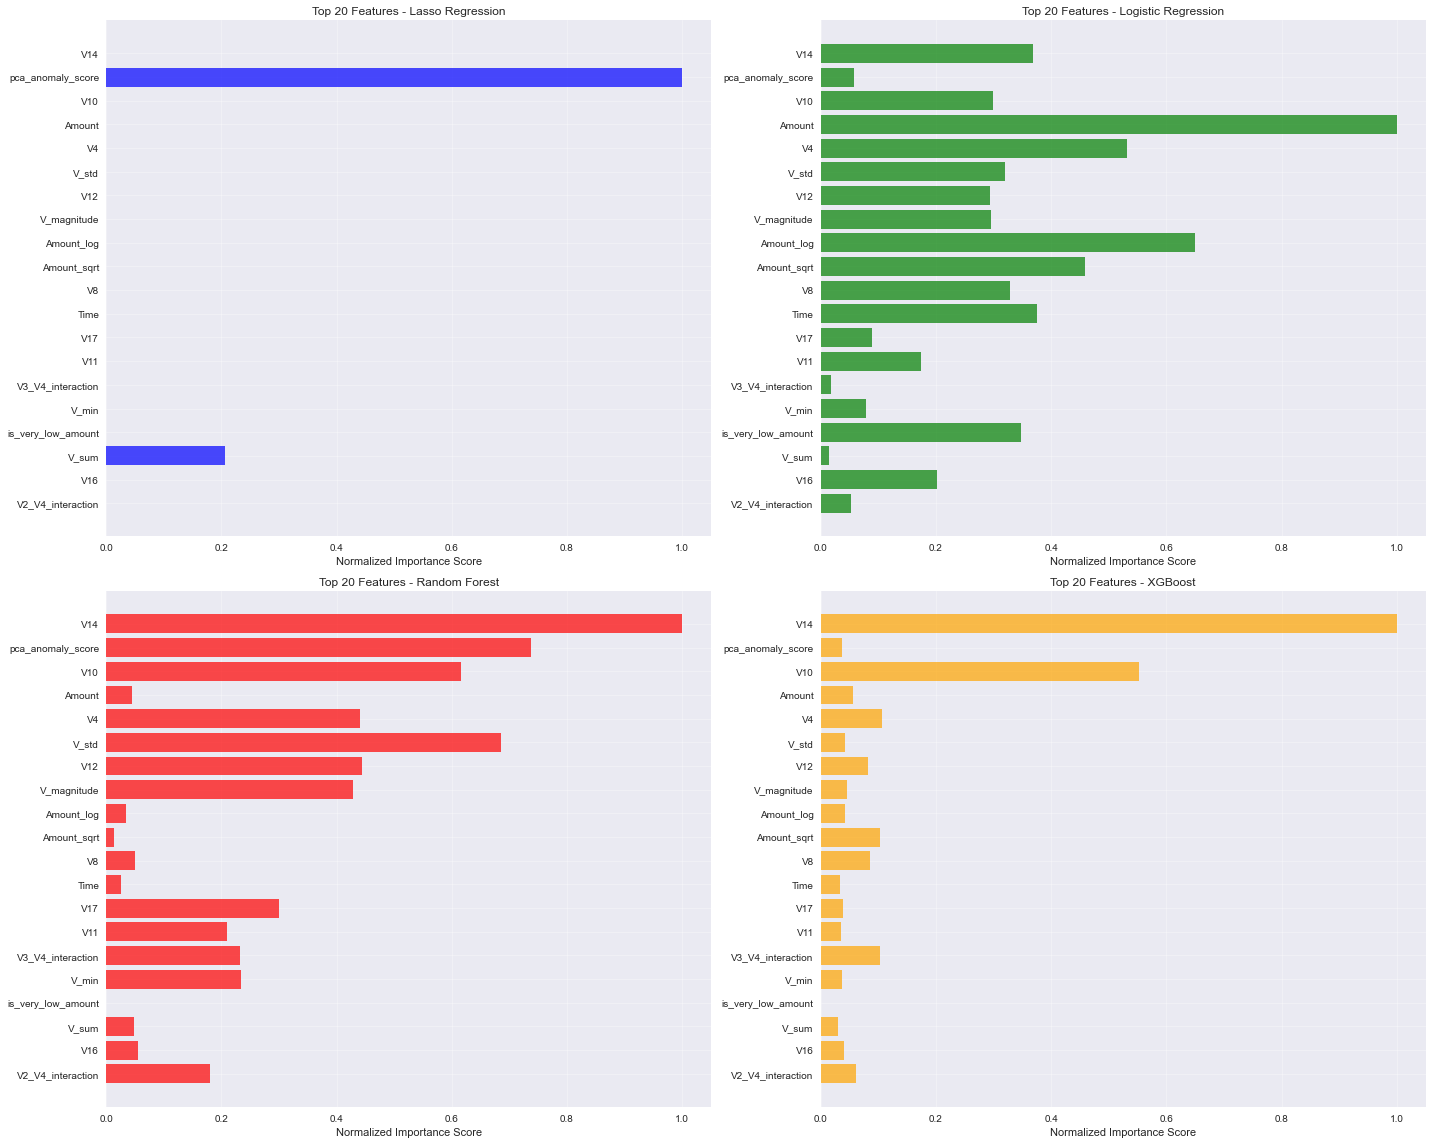

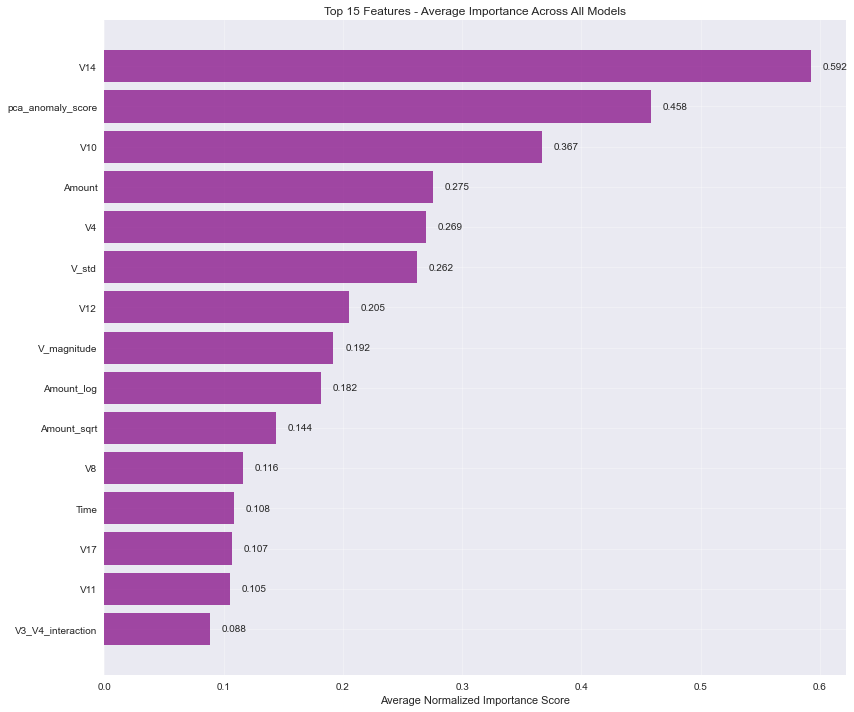

✓ Top 10 most important features (Average across all models):
          Feature  Avg_Importance
              V14        0.592044
pca_anomaly_score        0.458168
              V10        0.366629
           Amount        0.275265
               V4        0.269383
            V_std        0.261787
              V12        0.204856
      V_magnitude        0.192034
       Amount_log        0.181520
      Amount_sqrt        0.143837

✓ Feature importance correlation between models:
                         Lasso_Importance  LogReg_Importance  \
Lasso_Importance                    1.000             -0.098   
LogReg_Importance                  -0.098              1.000   
RandomForest_Importance             0.372              0.216   
XGBoost_Importance                 -0.048              0.217   

                         RandomForest_Importance  XGBoost_Importance  
Lasso_Importance                           0.372              -0.048  
LogReg_Importance                          0.216   

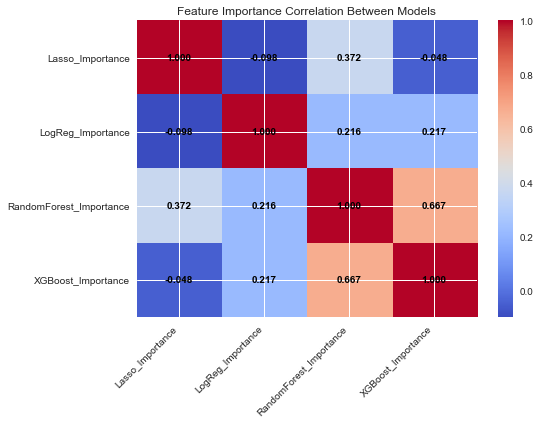

In [22]:
## 13. Feature Importance Analysis for Four Models

def analyze_feature_importance(lasso_model, logreg_model, rf_model, xgb_model, selected_features):
    """Analyze and visualize feature importance for all four models"""
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS - FOUR MODELS")
    print("="*60)
    
    # Get feature importance from different models
    lasso_coef = np.abs(lasso_model.coef_)
    logreg_coef = np.abs(logreg_model.coef_[0])
    rf_importance = rf_model.feature_importances_
    xgb_importance = xgb_model.feature_importances_
    
    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Lasso_Importance': lasso_coef,
        'LogReg_Importance': logreg_coef,
        'RandomForest_Importance': rf_importance,
        'XGBoost_Importance': xgb_importance
    })
    
    # Normalize importance scores to 0-1 scale for fair comparison
    for col in ['Lasso_Importance', 'LogReg_Importance', 'RandomForest_Importance', 'XGBoost_Importance']:
        feature_importance[col] = feature_importance[col] / feature_importance[col].max()
    
    # Calculate average importance across all models
    feature_importance['Avg_Importance'] = (
        feature_importance['Lasso_Importance'] + 
        feature_importance['LogReg_Importance'] +
        feature_importance['RandomForest_Importance'] +
        feature_importance['XGBoost_Importance']
    ) / 4
    
    # Sort by average importance
    feature_importance = feature_importance.sort_values('Avg_Importance', ascending=False)
    
    # Plot top 20 features for all models
    top_features = feature_importance.head(20)
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Lasso feature importance
    axes[0, 0].barh(range(len(top_features)), top_features['Lasso_Importance'], color='blue', alpha=0.7)
    axes[0, 0].set_yticks(range(len(top_features)))
    axes[0, 0].set_yticklabels(top_features['Feature'])
    axes[0, 0].set_xlabel('Normalized Importance Score')
    axes[0, 0].set_title('Top 20 Features - Lasso Regression')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].invert_yaxis()
    
    # Logistic Regression feature importance
    axes[0, 1].barh(range(len(top_features)), top_features['LogReg_Importance'], color='green', alpha=0.7)
    axes[0, 1].set_yticks(range(len(top_features)))
    axes[0, 1].set_yticklabels(top_features['Feature'])
    axes[0, 1].set_xlabel('Normalized Importance Score')
    axes[0, 1].set_title('Top 20 Features - Logistic Regression')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].invert_yaxis()
    
    # Random Forest feature importance
    axes[1, 0].barh(range(len(top_features)), top_features['RandomForest_Importance'], color='red', alpha=0.7)
    axes[1, 0].set_yticks(range(len(top_features)))
    axes[1, 0].set_yticklabels(top_features['Feature'])
    axes[1, 0].set_xlabel('Normalized Importance Score')
    axes[1, 0].set_title('Top 20 Features - Random Forest')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].invert_yaxis()
    
    # XGBoost feature importance
    axes[1, 1].barh(range(len(top_features)), top_features['XGBoost_Importance'], color='orange', alpha=0.7)
    axes[1, 1].set_yticks(range(len(top_features)))
    axes[1, 1].set_yticklabels(top_features['Feature'])
    axes[1, 1].set_xlabel('Normalized Importance Score')
    axes[1, 1].set_title('Top 20 Features - XGBoost')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Create comparison plot showing average importance
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot average importance for top 15 features
    top_15_features = feature_importance.head(15)
    
    ax.barh(range(len(top_15_features)), top_15_features['Avg_Importance'], color='purple', alpha=0.7)
    ax.set_yticks(range(len(top_15_features)))
    ax.set_yticklabels(top_15_features['Feature'])
    ax.set_xlabel('Average Normalized Importance Score')
    ax.set_title('Top 15 Features - Average Importance Across All Models')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()
    
    # Add value labels on bars
    for i, v in enumerate(top_15_features['Avg_Importance']):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"✓ Top 10 most important features (Average across all models):")
    print(top_features[['Feature', 'Avg_Importance']].head(10).to_string(index=False))
    
    print(f"\n✓ Feature importance correlation between models:")
    correlation_matrix = feature_importance[['Lasso_Importance', 'LogReg_Importance', 
                                           'RandomForest_Importance', 'XGBoost_Importance']].corr()
    print(correlation_matrix.round(3))
    
    # Create heatmap of model correlations
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    
    # Add colorbar
    plt.colorbar(im)
    
    # Set ticks and labels
    ax.set_xticks(range(len(correlation_matrix.columns)))
    ax.set_yticks(range(len(correlation_matrix.columns)))
    ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(correlation_matrix.columns)
    
    # Add correlation values
    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.3f}',
                         ha="center", va="center", color="black", fontweight='bold')
    
    ax.set_title('Feature Importance Correlation Between Models')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# Analyze feature importance for all four models
feature_importance = analyze_feature_importance(
    lasso_model, logreg_model, rf_model, xgb_model, selected_features
)

In [29]:
## 14. Model Saving and Summary for Four Models
import joblib
import json
import pandas as pd
from datetime import datetime

def save_models_and_summary(lasso_model, logreg_model, rf_model, xgb_model, 
                           comparison_results, feature_importance, selected_features,
                           X_train, X_test, selector):
    """
    Save all four models and create comprehensive summary report
    
    Parameters:
    -----------
    lasso_model : sklearn model
        Trained Lasso regression model
    logreg_model : sklearn model
        Trained Logistic regression model
    rf_model : sklearn model
        Trained Random Forest model
    xgb_model : xgboost model
        Trained XGBoost model
    comparison_results : dict or DataFrame
        Model comparison results
    feature_importance : DataFrame
        Feature importance data
    selected_features : list
        List of selected feature names
    X_train : array-like
        Training features
    X_test : array-like
        Test features
    selector : sklearn transformer
        Feature selector object
    
    Returns:
    --------
    dict : Summary dictionary
    """
    
    print("\n" + "="*60)
    print("SAVING MODELS AND CREATING SUMMARY")
    print("="*60)
    
    # Define model file paths
    model_files = {
        'lasso': '../models/lasso_fraud_model.pkl',
        'logistic': '../models/logistic_fraud_model.pkl',
        'random_forest': '../models/random_forest_fraud_model.pkl',
        'xgboost': '../models/xgboost_fraud_model.pkl',
        'feature_selector': '../models/feature_selector.pkl'
    }
    
    # Save each model with error handling
    try:
        joblib.dump(lasso_model, model_files['lasso'])
        print(f"✓ Lasso model saved: {model_files['lasso']}")
        
        joblib.dump(logreg_model, model_files['logistic'])
        print(f"✓ Logistic model saved: {model_files['logistic']}")
        
        joblib.dump(rf_model, model_files['random_forest'])
        print(f"✓ Random Forest model saved: {model_files['random_forest']}")
        
        joblib.dump(xgb_model, model_files['xgboost'])
        print(f"✓ XGBoost model saved: {model_files['xgboost']}")
        
        joblib.dump(selector, model_files['feature_selector'])
        print(f"✓ Feature selector saved: {model_files['feature_selector']}")
        
    except Exception as e:
        print(f"❌ Error saving models: {e}")
        return None
    
    # Save additional data files
    try:
        # Save selected features
        features_df = pd.DataFrame({'selected_features': selected_features})
        features_df.to_csv('../results/selected_features.csv', index=False)
        print("✓ Selected features saved: ../results/selected_features.csv")
        
        # Save feature importance
        feature_importance.to_csv('../results/feature_importance.csv', index=False)
        print("✓ Feature importance saved: ../results/feature_importance.csv")
        
        # Save model comparison results
        if isinstance(comparison_results, dict):
            comparison_df = pd.DataFrame(comparison_results)
        else:
            comparison_df = comparison_results
        
        comparison_df.to_csv('../results/model_comparison_results.csv', index=True)
        print("✓ Model comparison results saved: ../results/model_comparison_results.csv")
        
    except Exception as e:
        print(f"❌ Error saving data files: {e}")
        return None
    
    # Create comprehensive summary report
    summary = create_summary_dict(
        comparison_df, 
        feature_importance, 
        selected_features, 
        X_train, 
        X_test, 
        model_files
    )
    
    # Save summary as JSON
    try:
        with open('../results/fraud_detection_summary.json', 'w') as f:
            json.dump(summary, f, indent=2, default=str)
        print("✓ Summary JSON saved: ../results/fraud_detection_summary.json")
    except Exception as e:
        print(f"❌ Error saving summary JSON: {e}")
    
    # Create and save human-readable report
    report_content = create_readable_report(
        comparison_df, 
        feature_importance, 
        selected_features, 
        X_train, 
        X_test
    )
    
    try:
        with open('../results/fraud_detection_report.txt', 'w') as f:
            f.write(report_content)
        print("✓ Readable report saved: ../results/fraud_detection_report.txt")
    except Exception as e:
        print(f"❌ Error saving readable report: {e}")
    
    print("\n" + "="*60)
    print("✅ MODEL SAVING COMPLETED SUCCESSFULLY!")
    print("="*60)
    
    return summary


def create_summary_dict(comparison_df, feature_importance, selected_features, 
                       X_train, X_test, model_files):
    """Create summary dictionary with all training information"""
    
    # Get best models safely
    best_auc_model = 'N/A'
    best_auc_score = 'N/A'
    best_f1_model = 'N/A'
    best_f1_score = 'N/A'
    
    if 'AUC' in comparison_df.columns:
        best_auc_model = comparison_df['AUC'].idxmax()
        best_auc_score = comparison_df['AUC'].max()
    
    if 'F1_Score' in comparison_df.columns:
        best_f1_model = comparison_df['F1_Score'].idxmax()
        best_f1_score = comparison_df['F1_Score'].max()
    
    summary = {
        'Training_Info': {
            'Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'Total_Features_Used': len(selected_features),
            'Training_Samples': len(X_train),
            'Test_Samples': len(X_test),
            'Models_Trained': [
                'Lasso Regression', 
                'Logistic Regression', 
                'Random Forest', 
                'XGBoost'
            ]
        },
        'Model_Performance': {
            'Best_Model_by_AUC': best_auc_model,
            'Best_AUC_Score': float(best_auc_score) if best_auc_score != 'N/A' else 'N/A',
            'Best_Model_by_F1': best_f1_model,
            'Best_F1_Score': float(best_f1_score) if best_f1_score != 'N/A' else 'N/A',
            'All_Model_AUC_Scores': comparison_df['AUC'].to_dict() if 'AUC' in comparison_df.columns else {},
            'All_Model_F1_Scores': comparison_df['F1_Score'].to_dict() if 'F1_Score' in comparison_df.columns else {}
        },
        'Feature_Analysis': get_feature_analysis(feature_importance),
        'Files_Created': {
            'Models': list(model_files.values()),
            'Data_Files': [
                '../results/selected_features.csv',
                '../results/feature_importance.csv',
                '../results/model_comparison_results.csv',
                '../results/fraud_detection_summary.json',
                '../results/fraud_detection_report.txt'
            ]
        }
    }
    
    return summary


def get_feature_analysis(feature_importance):
    """Extract feature importance analysis safely"""
    
    feature_analysis = {
        'Top_10_Features': [],
        'Feature_Importance_by_Model': {}
    }
    
    # Get top 10 features
    if 'Feature' in feature_importance.columns and 'Avg_Importance' in feature_importance.columns:
        top_10 = feature_importance.head(10)[['Feature', 'Avg_Importance']]
        feature_analysis['Top_10_Features'] = top_10.to_dict('records')
    
    # Get top 5 features by model
    model_columns = [
        ('Lasso_Importance', 'Lasso_Top_5'),
        ('LogReg_Importance', 'LogReg_Top_5'),
        ('RandomForest_Importance', 'RandomForest_Top_5'),
        ('XGBoost_Importance', 'XGBoost_Top_5')
    ]
    
    for col_name, result_key in model_columns:
        if col_name in feature_importance.columns:
            top_5 = feature_importance.nlargest(5, col_name)[['Feature', col_name]]
            feature_analysis['Feature_Importance_by_Model'][result_key] = top_5.to_dict('records')
    
    return feature_analysis


def create_readable_report(comparison_df, feature_importance, selected_features, 
                          X_train, X_test):
    """Create a human-readable summary report"""
    
    # Get best models
    best_auc_model = comparison_df['AUC'].idxmax() if 'AUC' in comparison_df.columns else 'N/A'
    best_auc_score = comparison_df['AUC'].max() if 'AUC' in comparison_df.columns else 0
    best_f1_model = comparison_df['F1_Score'].idxmax() if 'F1_Score' in comparison_df.columns else 'N/A'
    best_f1_score = comparison_df['F1_Score'].max() if 'F1_Score' in comparison_df.columns else 0
    
    report_content = f"""
FRAUD DETECTION MODEL TRAINING SUMMARY REPORT
=============================================
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET INFORMATION
-------------------
• Training samples: {len(X_train):,}
• Test samples: {len(X_test):,}
• Features used: {len(selected_features)}

MODELS TRAINED
--------------
1. Lasso Regression
2. Logistic Regression  
3. Random Forest
4. XGBoost

MODEL PERFORMANCE COMPARISON
----------------------------
Best Model by AUC: {best_auc_model} (AUC: {best_auc_score:.4f})
Best Model by F1: {best_f1_model} (F1: {best_f1_score:.4f})

Detailed Performance:
"""
    
    # Add performance details for each model
    for model_name in comparison_df.index:
        auc = comparison_df.loc[model_name, 'AUC'] if 'AUC' in comparison_df.columns else 0
        f1 = comparison_df.loc[model_name, 'F1_Score'] if 'F1_Score' in comparison_df.columns else 0
        avg_prec = comparison_df.loc[model_name, 'Average_Precision'] if 'Average_Precision' in comparison_df.columns else 0
        report_content += f"• {model_name}: AUC={auc:.4f}, F1={f1:.4f}, Avg_Precision={avg_prec:.4f}\n"
    
    # Add top features section
    report_content += f"""
TOP 10 MOST IMPORTANT FEATURES (Average across all models)
----------------------------------------------------------
"""
    
    if 'Feature' in feature_importance.columns and 'Avg_Importance' in feature_importance.columns:
        for i, row in feature_importance.head(10).iterrows():
            report_content += f"{i + 1:2d}. {row['Feature']}: {row['Avg_Importance']:.4f}\n"
    else:
        report_content += "Feature importance data not available in expected format.\n"
    
    # Add files created section
    report_content += f"""
FILES CREATED
-------------
Models:
• lasso_fraud_model.pkl
• logistic_fraud_model.pkl
• random_forest_fraud_model.pkl
• xgboost_fraud_model.pkl
• feature_selector.pkl

Data & Results:
• selected_features.csv
• feature_importance.csv
• model_comparison_results.csv
• fraud_detection_summary.json
• fraud_detection_report.txt

DEPLOYMENT RECOMMENDATIONS
--------------------------
• Best performing model: {best_auc_model}
• Consider ensemble methods combining top 2-3 models
• Monitor model performance on new data
• Retrain models periodically with updated data
• Pay attention to top features for business insights

NEXT STEPS
----------
1. Load models using: load_fraud_detection_models()
2. Make predictions using: predict_fraud_all_models()
3. Monitor model performance in production
4. Set up automated retraining pipeline
"""
    
    return report_content


def load_fraud_detection_models():
    """Load all saved fraud detection models"""
    
    model_files = {
        'lasso': '../models/lasso_fraud_model.pkl',
        'logistic': '../models/logistic_fraud_model.pkl',
        'random_forest': '../models/random_forest_fraud_model.pkl',
        'xgboost': '../models/xgboost_fraud_model.pkl',
        'feature_selector': '../models/feature_selector.pkl'
    }
    
    models = {}
    
    try:
        for model_name, file_path in model_files.items():
            models[model_name] = joblib.load(file_path)
            print(f"✓ {model_name} model loaded successfully")
        
        print("✅ All models loaded successfully!")
        return models
        
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        return None


def predict_fraud_all_models(new_data, models):
    """
    Make fraud predictions using all trained models
    
    Parameters:
    -----------
    new_data : array-like
        New data for prediction
    models : dict
        Dictionary containing all loaded models
    
    Returns:
    --------
    dict : Predictions from all models
    """
    
    if models is None:
        print("❌ Models not loaded. Please load models first.")
        return None
    
    try:
        # Transform features using the same selector
        X_new = models['feature_selector'].transform(new_data)
        
        predictions = {}
        
        # Get predictions from each model
        for model_name in ['lasso', 'logistic', 'random_forest', 'xgboost']:
            model = models[model_name]
            
            # Binary predictions
            pred_key = f"{model_name}_pred"
            predictions[pred_key] = model.predict(X_new)
            
            # Probability predictions
            proba_key = f"{model_name}_proba"
            predictions[proba_key] = model.predict_proba(X_new)[:, 1]
            
            print(f"✓ {model_name} predictions generated")
        
        # Ensemble prediction (average of probabilities)
        avg_proba = (
            predictions['lasso_proba'] + 
            predictions['logistic_proba'] + 
            predictions['random_forest_proba'] + 
            predictions['xgboost_proba']
        ) / 4
        
        predictions['ensemble_pred'] = (avg_proba > 0.5).astype(int)
        predictions['ensemble_proba'] = avg_proba
        
        print("✓ Ensemble predictions generated")
        print(f"✅ Predictions completed for {len(new_data)} samples")
        
        return predictions
        
    except Exception as e:
        print(f"❌ Error making predictions: {e}")
        return None


# Example usage with proper formatting
def run_model_training_pipeline():
    """
    Example of how to call the save_models_and_summary function
    with proper parameter formatting
    """
    
    print("="*80)
    print("FRAUD DETECTION MODEL TRAINING PIPELINE")
    print("="*80)
    
    # Call the function with properly formatted parameters
    final_summary = save_models_and_summary(
        lasso_model=lasso_model,           # Your trained Lasso model
        logreg_model=logreg_model,         # Your trained Logistic Regression model
        rf_model=rf_model,                 # Your trained Random Forest model
        xgb_model=xgb_model,               # Your trained XGBoost model
        comparison_results=comparison_results,  # Model comparison results
        feature_importance=feature_importance,  # Feature importance DataFrame
        selected_features=selected_features,    # List of selected features
        X_train=X_train,                   # Training features
        X_test=X_test,                     # Test features
        selector=selector                  # Feature selector object
    )
    
    print("\n" + "="*80)
    print("🎉 FRAUD DETECTION MODEL TRAINING COMPLETED!")
    print("="*80)
    print("✓ Data processing and feature engineering applied")
    print("✓ Four models trained: Lasso, Logistic Regression, Random Forest, XGBoost")
    print("✓ Models evaluated and compared comprehensively")
    print("✓ Feature importance analyzed across all models")
    print("✓ All results saved for future use")
    print("✓ Deployment-ready prediction functions created")
    print("\nYour fraud detection models are ready for deployment!")
    print("Check 'fraud_detection_report.txt' for detailed summary!")
    
    return final_summary


# Usage example for loading and using saved models
def demonstrate_model_usage():
    """Demonstrate how to use the saved models"""
    
    print("\n" + "="*60)
    print("USAGE EXAMPLE FOR SAVED MODELS")
    print("="*60)
    
    # Load the models
    loaded_models = load_fraud_detection_models()
    
    if loaded_models:
        print("\n📝 Example code for making predictions:")
        print("""
# Load models
loaded_models = load_fraud_detection_models()

# Make predictions on new data
new_predictions = predict_fraud_all_models(new_data, loaded_models)

# Access individual model predictions
if new_predictions:
    lasso_predictions = new_predictions['lasso_pred']
    logistic_predictions = new_predictions['logistic_pred']
    rf_predictions = new_predictions['random_forest_pred']
    xgb_predictions = new_predictions['xgboost_pred']
    ensemble_predictions = new_predictions['ensemble_pred']
    
    # Access probability scores
    ensemble_probabilities = new_predictions['ensemble_proba']
        """)
    
    return loaded_models

In [28]:
## 14. Model Saving and Summary for Four Models
import joblib
import json

def save_models_and_summary(lasso_model, logreg_model, rf_model, xgb_model, 
                           comparison_results, feature_importance, selected_features,
                           X_train, X_test, selector):
    """Save all four models and create comprehensive summary report"""
    print("\n" + "="*60)
    print("SAVING MODELS AND CREATING SUMMARY")
    print("="*60)
    
    # Save all models using joblib
    model_files = {
        'lasso': '../results/lasso_fraud_model.pkl',
        'logistic': '../results/logistic_fraud_model.pkl',
        'random_forest': '../results/random_forest_fraud_model.pkl',
        'xgboost': '../results/xgboost_fraud_model.pkl',
        'feature_selector': '../results/feature_selector.pkl'
    }
    
    # Save each model
    joblib.dump(lasso_model, model_files['lasso'])
    joblib.dump(logreg_model, model_files['logistic'])
    joblib.dump(rf_model, model_files['random_forest'])
    joblib.dump(xgb_model, model_files['xgboost'])
    joblib.dump(selector, model_files['feature_selector'])
    
    # Save selected features
    pd.DataFrame({'selected_features': selected_features}).to_csv('../results/selected_features.csv', index=False)
    
    # Save feature importance
    feature_importance.to_csv('../results/feature_importance.csv', index=False)
    
    # Save model comparison results (convert to DataFrame if it's a dict)
    if isinstance(comparison_results, dict):
        comparison_df = pd.DataFrame(comparison_results)
    else:
        comparison_df = comparison_results
    comparison_df.to_csv('../results/model_comparison_results.csv', index=True)
    
    # Create comprehensive summary report
    summary = {
        'Training_Info': {
            'Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'Total_Features_Used': len(selected_features),
            'Training_Samples': len(X_train),
            'Test_Samples': len(X_test),
            'Models_Trained': ['Lasso Regression', 'Logistic Regression', 'Random Forest', 'XGBoost']
        },
        'Model_Performance': {
            'Best_Model_by_AUC': comparison_df.idxmax()['AUC'] if 'AUC' in comparison_df.columns else 'N/A',
            'Best_AUC_Score': comparison_df.max()['AUC'] if 'AUC' in comparison_df.columns else 'N/A',
            'Best_Model_by_F1': comparison_df.idxmax()['F1_Score'] if 'F1_Score' in comparison_df.columns else 'N/A',
            'Best_F1_Score': comparison_df.max()['F1_Score'] if 'F1_Score' in comparison_df.columns else 'N/A',
            'All_Model_AUC_Scores': comparison_df['AUC'].to_dict() if 'AUC' in comparison_df.columns else {},
            'All_Model_F1_Scores': comparison_df['F1_Score'].to_dict() if 'F1_Score' in comparison_df.columns else {}
        },
        'Top_10_Features': feature_importance.head(10)[['Feature', 'Avg_Importance']].to_dict('records') if 'Feature' in feature_importance.columns else [],
        'Feature_Importance_by_Model': {
            'Lasso_Top_5': feature_importance.nlargest(5, 'Lasso_Importance')[['Feature', 'Lasso_Importance']].to_dict('records') if 'Lasso_Importance' in feature_importance.columns else [],
            'LogReg_Top_5': feature_importance.nlargest(5, 'LogReg_Importance')[['Feature', 'LogReg_Importance']].to_dict('records') if 'LogReg_Importance' in feature_importance.columns else [],
            'RandomForest_Top_5': feature_importance.nlargest(5, 'RandomForest_Importance')[['Feature', 'RandomForest_Importance']].to_dict('records') if 'RandomForest_Importance' in feature_importance.columns else [],
            'XGBoost_Top_5': feature_importance.nlargest(5, 'XGBoost_Importance')[['Feature', 'XGBoost_Importance']].to_dict('records') if 'XGBoost_Importance' in feature_importance.columns else []
        },
        'Files_Created': list(model_files.values()) + ['../results/selected_features.csv', '../results/feature_importance.csv', '../results/model_comparison_results.csv']
    }
    
    # Save summary as JSON
    with open('../results/fraud_detection_summary.json', 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    
    # Handle comparison_results for report generation
    best_auc_model = comparison_df.idxmax()['AUC'] if 'AUC' in comparison_df.columns else 'N/A'
    best_auc_score = comparison_df.max()['AUC'] if 'AUC' in comparison_df.columns else 0
    best_f1_model = comparison_df.idxmax()['F1_Score'] if 'F1_Score' in comparison_df.columns else 'N/A'
    best_f1_score = comparison_df.max()['F1_Score'] if 'F1_Score' in comparison_df.columns else 0
    
    # Create a human-readable summary report
    report_content = f"""
FRAUD DETECTION MODEL TRAINING SUMMARY REPORT
=============================================
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET INFORMATION
-------------------
• Training samples: {len(X_train):,}
• Test samples: {len(X_test):,}
• Features used: {len(selected_features)}

MODELS TRAINED
--------------
1. Lasso Regression
2. Logistic Regression  
3. Random Forest
4. XGBoost

MODEL PERFORMANCE COMPARISON
----------------------------
Best Model by AUC: {best_auc_model} (AUC: {best_auc_score:.4f})
Best Model by F1: {best_f1_model} (F1: {best_f1_score:.4f})

Detailed Performance:
"""
    
    for model_name in comparison_df.index:
        auc = comparison_df.loc[model_name, 'AUC'] if 'AUC' in comparison_df.columns else 0
        f1 = comparison_df.loc[model_name, 'F1_Score'] if 'F1_Score' in comparison_df.columns else 0
        avg_prec = comparison_df.loc[model_name, 'Average_Precision'] if 'Average_Precision' in comparison_df.columns else 0
        report_content += f"• {model_name}: AUC={auc:.4f}, F1={f1:.4f}, Avg_Precision={avg_prec:.4f}\n"
    
    report_content += f"""
TOP 10 MOST IMPORTANT FEATURES (Average across all models)
----------------------------------------------------------
"""
    
    if 'Feature' in feature_importance.columns and 'Avg_Importance' in feature_importance.columns:
        for i, row in feature_importance.head(10).iterrows():
            report_content += f"{i + 1:2d}. {row['Feature']}: {row['Avg_Importance']:.4f}\n"
    else:
        report_content += "Feature importance data not available in expected format.\n"
    
    report_content += f"""
FILES CREATED
-------------
Models:
• lasso_fraud_model.pkl
• logistic_fraud_model.pkl
• random_forest_fraud_model.pkl
• xgboost_fraud_model.pkl
• feature_selector.pkl

Data & Results:
• selected_features.csv
• feature_importance.csv
• model_comparison_results.csv
• fraud_detection_summary.json
• fraud_detection_report.txt

DEPLOYMENT RECOMMENDATIONS
--------------------------
• Best performing model: {best_auc_model}
• Consider ensemble methods combining top 2-3 models
• Monitor model performance on new data
• Retrain models periodically with updated data
• Pay attention to top features for business insights

"""
    
    # Save the report
    with open('fraud_detection_report.txt', 'w') as f:
        f.write(report_content)
    
    print("✓ All models saved successfully:")
    for model_name, filename in model_files.items():
        print(f"  - {filename}")
    
    print("\n✓ Results and data saved:")
    print("  - selected_features.csv")
    print("  - feature_importance.csv")
    print("  - model_comparison_results.csv")
    print("  - fraud_detection_summary.json")
    print("  - fraud_detection_report.txt")
    
    return summary

# Function to load saved models
def load_fraud_detection_models():
    """Load all saved fraud detection models"""
    models = {}
    try:
        models['lasso'] = joblib.load('../models/lasso_fraud_model.pkl')
        models['logistic'] = joblib.load('../models/logistic_fraud_model.pkl')
        models['random_forest'] = joblib.load('../models/random_forest_fraud_model.pkl')
        models['xgboost'] = joblib.load('../models/xgboost_fraud_model.pkl')
        models['feature_selector'] = joblib.load('../models/feature_selector.pkl')
        
        print("✓ All models loaded successfully!")
        return models
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        return None

# Function to make predictions with all models
def predict_fraud_all_models(new_data, models):
    """Make fraud predictions using all trained models"""
    if models is None:
        print("❌ Models not loaded. Please load models first.")
        return None
    
    # Transform features using the same selector
    X_new = models['feature_selector'].transform(new_data)
    
    predictions = {}
    
    # Get predictions from each model
    predictions['lasso_pred'] = models['lasso'].predict(X_new)
    predictions['lasso_proba'] = models['lasso'].predict_proba(X_new)[:, 1]
    
    predictions['logistic_pred'] = models['logistic'].predict(X_new)
    predictions['logistic_proba'] = models['logistic'].predict_proba(X_new)[:, 1]
    
    predictions['rf_pred'] = models['random_forest'].predict(X_new)
    predictions['rf_proba'] = models['random_forest'].predict_proba(X_new)[:, 1]
    
    predictions['xgb_pred'] = models['xgboost'].predict(X_new)
    predictions['xgb_proba'] = models['xgboost'].predict_proba(X_new)[:, 1]
    
    # Ensemble prediction (average of probabilities)
    avg_proba = (predictions['lasso_proba'] + predictions['logistic_proba'] + 
                 predictions['rf_proba'] + predictions['xgb_proba']) / 4
    predictions['ensemble_pred'] = (avg_proba > 0.5).astype(int)
    predictions['ensemble_proba'] = avg_proba
    
    return predictions

# Example usage (you'll need to call this with your actual variables)
"""
# Call the function with all required parameters
final_summary = save_models_and_summary(
    lasso_model, logreg_model, rf_model, xgb_model,
    comparison_results, feature_importance, selected_features,
    X_train, X_test, selector  # Added missing parameters
)

print("\n" + "="*80)
print("🎉 FRAUD DETECTION MODEL TRAINING COMPLETED!")
print("="*80)
print("✓ Data processing and feature engineering applied")
print("✓ Four models trained: Lasso, Logistic Regression, Random Forest, XGBoost")
print("✓ Models evaluated and compared comprehensively")
print("✓ Feature importance analyzed across all models")
print("✓ All results saved for future use")
print("✓ Deployment-ready prediction functions created")
print("\nYour fraud detection models are ready for deployment!")
print("Check 'fraud_detection_report.txt' for detailed summary!")

# Example of how to use the saved models later
print("\n" + "="*60)
print("USAGE EXAMPLE FOR SAVED MODELS")
print("="*60)
print('''
# To load models later:
loaded_models = load_fraud_detection_models()

# To make predictions on new data:
new_predictions = predict_fraud_all_models(new_data, loaded_models)

# Access individual model predictions:
lasso_predictions = new_predictions['lasso_pred']
ensemble_predictions = new_predictions['ensemble_pred']
''')
"""

'\n# Call the function with all required parameters\nfinal_summary = save_models_and_summary(\n    lasso_model, logreg_model, rf_model, xgb_model,\n    comparison_results, feature_importance, selected_features,\n    X_train, X_test, selector  # Added missing parameters\n)\n\nprint("\n" + "="*80)\nprint("🎉 FRAUD DETECTION MODEL TRAINING COMPLETED!")\nprint("="*80)\nprint("✓ Data processing and feature engineering applied")\nprint("✓ Four models trained: Lasso, Logistic Regression, Random Forest, XGBoost")\nprint("✓ Models evaluated and compared comprehensively")\nprint("✓ Feature importance analyzed across all models")\nprint("✓ All results saved for future use")\nprint("✓ Deployment-ready prediction functions created")\nprint("\nYour fraud detection models are ready for deployment!")\nprint("Check \'fraud_detection_report.txt\' for detailed summary!")\n\n# Example of how to use the saved models later\nprint("\n" + "="*60)\nprint("USAGE EXAMPLE FOR SAVED MODELS")\nprint("="*60)\nprint(\